In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn.apionly as sns 
sns.set_context("notebook") # can set to poster to make really large

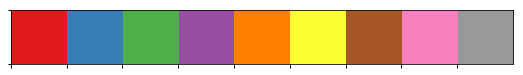

In [2]:
output = sns.choose_colorbrewer_palette(data_type="qualitative") # lots of choose options in seaborn

In [3]:
sns.set()

---

### Data prep

1. load data
2. train test split
3. interaction terms
4. take natural log of followers

In [4]:
data = pd.read_csv('df_by_playlist.csv',index_col=0)

In [121]:
names = list(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness',
       'tempo', 'valence', 'explicit', 'mode', 'num_tracks',
       'track_feat', 'track_remast', 'track_remix', 'album_feat',
       'album_deluxe', 'album_best', 'time_sign_0.0', 'time_sign_3.0',
       'time_sign_4.0', 'key_0.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0',
       'key_5.0', 'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0','key_11.0'])

In [122]:
# splitting data

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(data.drop('followers',axis=1),data['followers'],test_size=0.2)

In [123]:
xtrain.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,...,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0
playlist_name,,,,,,,,,,,,,,,,,,,,,
Top Picks Pop,0.124546,0.635650,233676.450000,0.776950,0.000222,0.145665,-5.014050,48.050000,0.058780,121.083750,...,0,0,0,0,0,0,1,0,0,0
This Is: Skepta,0.131547,0.724478,197131.108696,0.743348,0.000350,0.195624,-6.287565,42.543478,0.218870,135.767283,...,0,0,0,0,0,0,0,0,0,0
Batman,0.005272,0.435100,267164.100000,0.894400,0.108865,0.267645,-4.823700,53.200000,0.081080,133.224900,...,1,0,0,0,0,0,0,0,0,0
(Descent) A Beginning,0.906870,0.216130,560991.565217,0.075721,0.907826,0.128530,-28.207957,35.782609,0.043517,100.026913,...,0,0,0,0,1,0,0,0,0,0
Brain Food,0.321189,0.554520,196525.860000,0.593780,0.674562,0.209068,-10.156320,57.740000,0.089916,124.427540,...,0,0,0,0,0,0,0,0,0,0


In [124]:
quant_predictors = list([predictor for predictor in names if xtrain.loc[:,predictor].unique().sum()!=1])

def interact(x,variable,predictors=quant_predictors):
    for predictor in predictors:
        x[variable+'_'+predictor] = x[variable]*x[predictor]
    return x

In [125]:
# using explicit interaction terms (even though GBRT sort of already can detect these)
#from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(degree=2)
#poly.fit_transform()

xtrain = interact(xtrain,'loudness')
xtrain = interact(xtrain,'danceability',list(['speechiness','tempo']))
xtest = interact(xtest,'loudness')
xtest = interact(xtest,'danceability',list(['speechiness','tempo']))


In [145]:
# Taking log of response variable to deal with outliers (right skewed distribution)
# Otherwise, since each progressive model fit focuses on steepest gradient, we would always favor fitting these outliers 
# Also don't want to worry about whether train or test set gets most extreme outlier
ytrain = np.log(ytrain+1)
ytest = np.log(ytest+1)

---

---

### Gradient Boosted Regression Model

In [147]:
# Gradient Boosted Regression
# learning rate: want to get smaller as get closer to "bottom"
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# FITTING STUMPs, if more than 1 predictor - need more depth
#also learning rate =1, just using gradient, if learning rate<1 you're slowing yourself down by multiplying "residual" by fraction

In [148]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
        test_dev[i] = est.loss_(y_test, pred) # can put in any loss you want (MSE, etc.)

    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

### Fitting for learning rate, max_depth, min_samples_leaf, max_features

In [202]:
param_grid = {'learning_rate': [0.1,0.01], 
              'max_depth': [4,8,12],
              'min_samples_leaf': [3,5,7],  
              'max_features': [0.3,0.6]} 

In [203]:
gb = GradientBoostingRegressor(n_estimators=600, loss='huber') # huber weights outliers less
gb_cv = GridSearchCV(gb, param_grid, cv=3, n_jobs=-1)
gb_cv.fit(xtrain, ytrain)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=600,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [4, 8, 12], 'min_samples_leaf': [3, 5, 7], 'max_features': [0.3, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [204]:
gb_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=12,
             max_features=0.3, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=7, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=600,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [205]:
bp = gb_cv.best_params_
print('Best Params: \n',bp)
print('Score: ',gb_cv.score(xtrain, ytrain))
print('MSE: ',mean_squared_error(ytrain, gb_cv.predict(xtrain)))
print('MAE: ',mean_absolute_error(ytrain, gb_cv.predict(xtrain)))

Best Params: 
 {'learning_rate': 0.01, 'max_depth': 12, 'max_features': 0.3, 'min_samples_leaf': 7}
Score:  0.93385286836
MSE:  0.689714320734
MAE:  0.286284349264


### Now fitting for just learning rate using 5-fold CV - want to avoid overfitting

In [206]:
param_grid2 = {'learning_rate': [0.1,0.01,0.001]}
gb2 = GradientBoostingRegressor(n_estimators=1000, 
                                loss="huber", 
                                max_depth=bp['max_depth'],
                                max_features=bp['max_features'],
                                min_samples_leaf=bp['min_samples_leaf'])
gb2_cv = GridSearchCV(gb2,param_grid2,cv=5)
gb2_cv.fit(xtrain,ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=12,
             max_features=0.3, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=7, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [207]:
gb2_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=12,
             max_features=0.3, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=7, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [208]:
bp2 = gb2_cv.best_params_
print('Best Params: \n',bp2)
print('Score: ',gb2_cv.score(xtrain, ytrain))
print('MSE: ',mean_squared_error(ytrain, gb2_cv.predict(xtrain)))
print('MAE: ',mean_absolute_error(ytrain, gb2_cv.predict(xtrain)))

Best Params: 
 {'learning_rate': 0.01}
Score:  0.94394701136
MSE:  0.584462969536
MAE:  0.199568703279


Relative importance of all variables


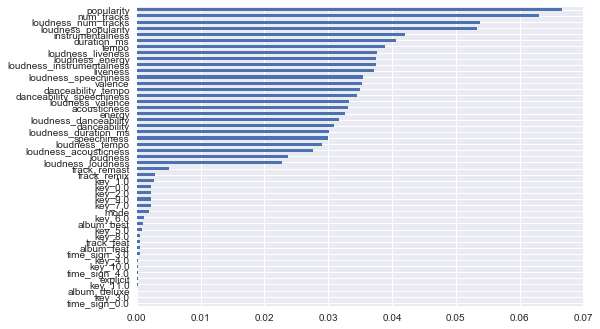

In [209]:
names_wInteraction = list(xtrain.keys().values)
indicators = list([predictor for predictor in names_wInteraction if xtrain.loc[:,predictor].unique().sum()==1])

print('Relative importance of all variables')
feature_imp = gb2_cv.best_estimator_.feature_importances_
pd.Series(feature_imp, index=names_wInteraction).sort_values().plot(kind="barh");

Relative importance of indicator variables


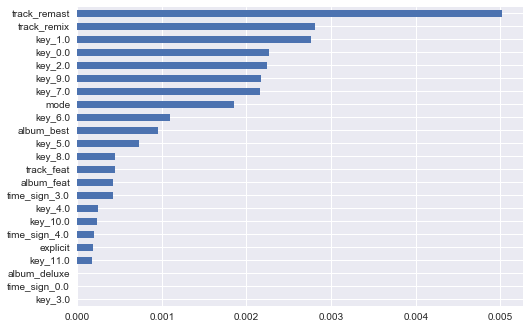

In [210]:
print('Relative importance of indicator variables')
pd.Series(feature_imp[feature_imp<0.01],index=indicators).sort_values().plot(kind='barh');

### Model Evaluation

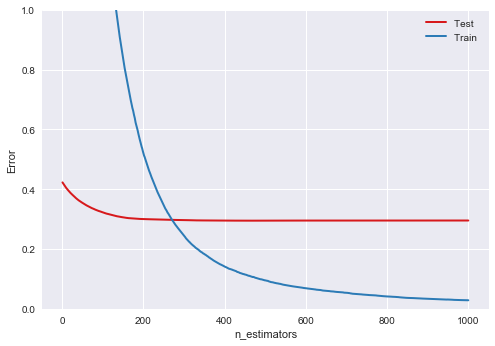

In [211]:
deviance_plot(gb2_cv.best_estimator_, xtest, ytest,ylim=(0,1));
plt.legend();

In [213]:
print('Best Params: \n',bp2)
print('Score (test set): ',gb2_cv.score(xtest, ytest))
print('MSE (test set): ',mean_squared_error(ytest, gb2_cv.predict(xtest)))
print('MAE (test set): ',mean_absolute_error(ytest, gb2_cv.predict(xtest)))

Best Params: 
 {'learning_rate': 0.01}
Score (test set):  0.416574732155
MSE (test set):  6.01199664126
MAE (test set):  1.69792493549


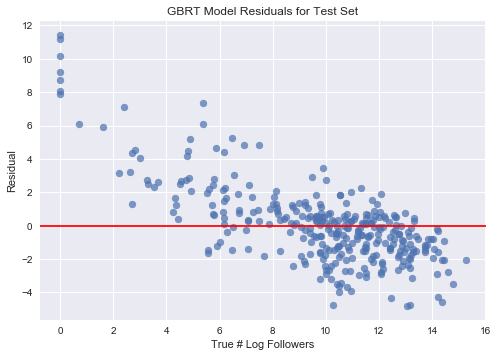

In [221]:
# Residual Plot

plt.scatter(ytest, gb2_cv.predict(xtest)-ytest,alpha=0.7)
plt.axhline(c='red')
plt.xlabel('True # Log Followers')
plt.ylabel('Residual')
plt.title('GBRT Model Residuals for Test Set')